# Setting

In [1]:
from pf_utils import DataManager, FinancialRatios, BacktestManager, MomentumPortfolio
from pf_widgets import WidgetUniverse, WidgetTransaction

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
metrics2 = [
    'total_return', 'cagr', 'monthly_vol', 'monthly_sharpe',
    'max_drawdown', 'avg_drawdown','avg_drawdown_days', 
]

path_data = 'data'
path_tran = 'transaction'

In [3]:
file_bt_price = 'kospi200_prices_000306_240707.csv'
file_bt_ratio = 'kospi200_ratios_170531_240930.csv'

# Data

## Universe: KOSPI200

In [4]:
#file = file_bt_price, # uncomment for backtesting
file = 'kospi200_prices.csv'

In [5]:
k200 = DataManager(
    universe = 'kospi200',
    file = file,
    path = path_data
)
k200.upload()

201 assets from 2021-01-04 to 2024-10-18 uploaded.
df_prices updated


In [6]:
df_k200 = k200.df_prices
assetnames_k200 = k200.get_names()

### data for backtesting

In [7]:
if k200.file_historical == file_bt_price:
    cond = df_k200.notna().sum(axis=1) > 170
    df_k200 = df_k200.loc[cond].dropna(axis=1)
df_k200.columns.size

201

## Ratios

In [8]:
WidgetUniverse

In [9]:
if k200.file_historical == file_bt_price:
    file = file_bt_ratio
else:
    file = 'kospi200_ratios.csv'

fr = FinancialRatios(file, path_data)

Financial ratios of 201 stocks from 2023-01-02 to 2024-10-18 loaded


In [10]:
start = '2023-01-01'
tickers = df_k200.columns.to_list()
kw = dict(
    freq = 'd',
    close_today = WidgetUniverse.values(1)
)
fr.download(tickers, start, **kw) if WidgetUniverse.values(0) else None

In [11]:
#fr.calc_rank(metrics='PER', date='start', topn=None)
fr.calc_rank(metrics='PER', topn=None)

Ranking score of PER on 2024-10-18


ticker
010060    0.000000
003030    0.006211
016380    0.015528
009970    0.015528
078930    0.024845
            ...   
009420    0.975155
329180    0.981366
377300    0.987578
450080    0.993789
004800    1.000000
Name: PER, Length: 162, dtype: float64

In [12]:
#fr.calc_historical()
fr.calc_historical(['PER', 'PBR'])

Historical of PER+PBR ranking score created


ticker  date      
005930  2023-01-02    1.115655
        2023-01-03    1.120757
        2023-01-04    1.146513
        2023-01-05    1.162310
        2023-01-06    1.167412
                        ...   
105630  2024-10-14    0.764144
        2024-10-15    0.774669
        2024-10-16    0.784669
        2024-10-17    0.742044
        2024-10-18    0.744544
Name: PER, Length: 87310, dtype: float64

In [13]:
#fr.get_stats(stats_daily=False)
fr.get_stats()

Returning stats of daily averages


,BPS,PER,PBR,EPS,DIV,DPS
start,2023-01-02,2023-01-02,2023-01-02,2023-01-02,2023-01-02,2023-01-02
end,2024-10-18,2024-10-18,2024-10-18,2024-10-18,2024-10-18,2024-10-18
mean,105808.1,69.2,2.3,8770.4,2.4,1816.9
std,3546.2,40.9,0.3,1357.3,0.1,122.5


## Reshape for backtest

In [14]:
df_p = fr.util_reshape(df_k200)

fratios_dict = dict()
for r in ['PER', 'PBR']:
    df = fr.interpolate(df_p, r)
    fratios_dict[r] = fr.util_reshape(df, stack=False)

In [15]:
fratios_dict[r].tail()

ticker,000080,000100,000120,000150,000210,000240,000270,000660,000670,000720,...,361610,373220,375500,377300,383220,402340,450080,454910,457190,489790
date,,,,,,,,,,,,,,,,,,,,,
2024-10-14,1.29,5.74,0.50,2.11,0.26,0.40,0.86,2.41,0.19,0.42,...,1.05,4.70,0.25,1.77,1.94,0.77,10.17,9.13,14.14,0.0
2024-10-15,1.29,5.95,0.49,2.08,0.25,0.40,0.85,2.48,0.19,0.41,...,1.03,4.67,0.25,1.78,1.88,0.77,9.69,9.08,13.91,0.0
2024-10-16,1.28,5.77,0.49,2.09,0.25,0.41,0.83,2.43,0.19,0.41,...,0.99,4.69,0.25,1.77,1.82,0.76,9.93,8.91,13.81,0.0
2024-10-17,1.28,5.59,0.49,2.30,0.25,0.40,0.81,2.52,0.17,0.42,...,1.00,4.60,0.27,1.75,1.79,0.78,9.82,9.16,13.38,0.0
2024-10-18,1.27,5.65,0.49,2.26,0.25,0.39,0.81,2.41,0.17,0.42,...,0.98,4.50,0.26,1.78,1.82,0.79,10.06,9.63,13.16,0.0


# Backtest

## Example

In [15]:
fratio = 'PER'
df_ratio = fratios_dict[fratio]

In [16]:
kwargs_bm = dict(
    initial_capital = 1e7,
    commissions = 0,
    align_axis = None, 
    days_in_year = 246,
    asset_names = assetnames_k200
)
bm = BacktestManager(df_k200, **kwargs_bm)

171 assets from 2017-05-10 to 2024-07-05 uploaded.
running self.util_check_days_in_year to check days in a year


In [17]:
bm.benchmark_ticker()

Benchmark is KODEX200


In [18]:
#bm.buy_n_hold(name='PER', weigh='equally')

In [19]:
select = 'f-ratio'
kwargs_build = dict(
    name=f'{select}', select =select, weigh='Equally', 
    n_assets=5, freq='Y', lookback='5d',
    df_ratio=df_ratio, ratio_descending=True
)
bm.build(**kwargs_build)

Backtesting 2 strategies: KODEX200, f-ratio


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.07it/s]

Returning stats


,KODEX200,f-ratio
start,2017-05-09,2017-05-09
end,2024-07-05,2024-07-05
total_return,0.545298,0.393314
cagr,0.062699,0.047437
calmar,0.164837,0.087122
max_drawdown,-0.38037,-0.544485
avg_drawdown,-0.04033,-0.085891
avg_drawdown_days,78.46875,126.75
daily_vol,0.18247,0.29995
daily_sharpe,0.432459,0.307699


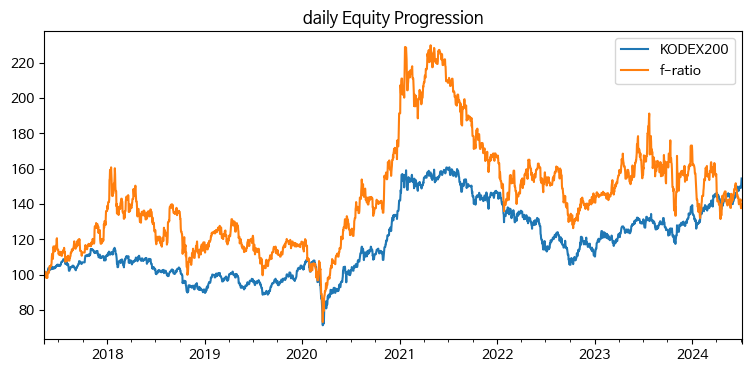

In [20]:
bm.run(figsize=(9,4), stats_sort_by='cagr')

In [21]:
bm.portfolios

0) KODEX200
1) f-ratio

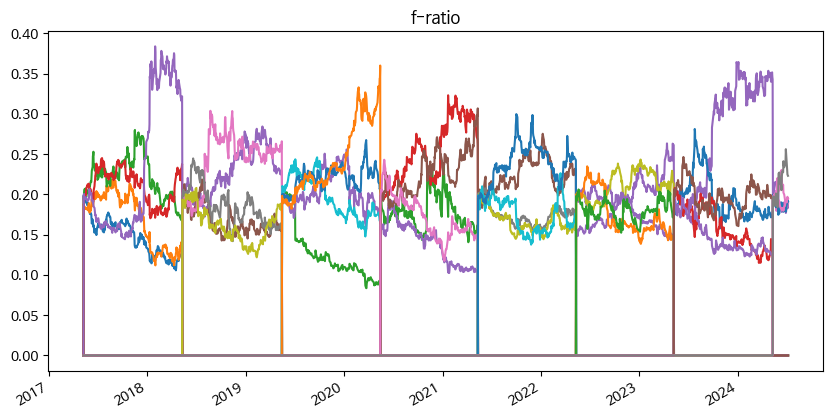

In [22]:
bm.plot_security_weights(1, legend=False)

## Parameter study

In [16]:
n_test = 500
df_train = df_k200.iloc[:-n_test]
df_test = df_k200.iloc[-n_test:]

In [17]:
kwargs_bm = dict(
    initial_capital = 1e7,
    commissions = 0,
    align_axis = None, 
    days_in_year = 246,
    asset_names = assetnames_k200
)

In [18]:
bm = BacktestManager(df_train, **kwargs_bm)

171 assets from 2017-05-10 to 2022-06-24 uploaded.
running self.util_check_days_in_year to check days in a year


In [19]:
from itertools import product

p_args = dict(
    #p_fr = ['PER', 'PBR', 'PER+PBR'],
    p_fr = ['PER'],
    p_ast = [5, 10, 20, 30],
    p_freq = [130, 250, 500],
    p_lb = [0, 5, 10, 20, 30, 60] # days
)
p_comb = list(product(*p_args.values()))
params = [{'name':'{}:a{}/f{}/lb{}'.format(*x),
           'df_ratio':x[0], 'n_assets':x[1], 'freq':x[2], 'lookback':x[3]} 
          for x in p_comb]

In [20]:
kwa_list = [{**x, 'df_ratio': fratios_dict[x['df_ratio']], 'lookback':f'{x['lookback']}days'} for x in params]
 
kwargs_build = dict(
    select='F-ratio', weigh='Equally', ratio_descending=False
)

bm.build_batch(*kwa_list, **kwargs_build)

In [21]:
df_res = bm.cross_validate(n_sample=20)

Cross-validating 72 strategies: PER:a5/f130/lb0, PER:a5/f130/lb5, ... , PER:a30/f500/lb60


100%|███████████████████████████████████████████████████████████████| 18/18 [00:22<00:00,  1.23s/it]


24.5 mins elapsed, 0.0 secs paused (0.0%)


In [22]:
df_cv = bm.get_cat_data(params)

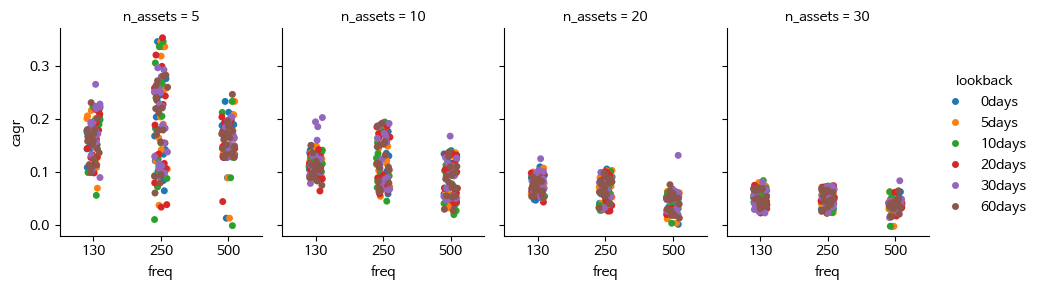

In [35]:
import seaborn as sns
_ = sns.catplot(data=df_cv, 
                x='freq', y='cagr', 
                col='n_assets', 
                hue='lookback',
                #kind="box", 
                height=3, aspect=.8)

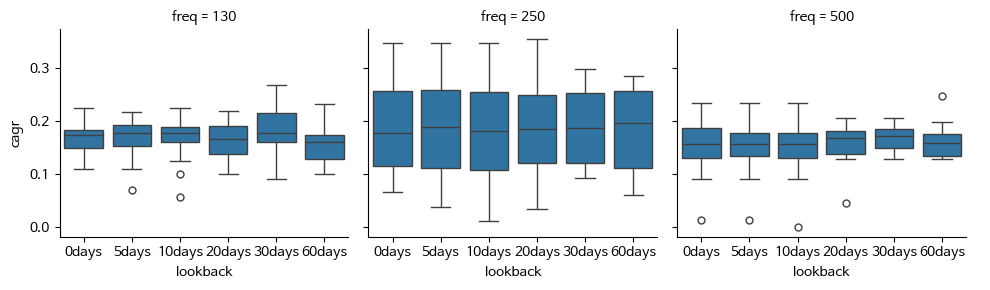

In [42]:
import seaborn as sns
_ = sns.catplot(data=df_cv.loc[df_cv.n_assets==5], 
                x='lookback', y='cagr', 
                col='freq',
                kind="box", 
                height=3, aspect=1.1)

### Validation

In [46]:
bm = BacktestManager(df_test, **kwargs_bm)
bm.benchmark_ticker()

171 assets from 2022-06-27 to 2024-07-05 uploaded.
running self.util_check_days_in_year to check days in a year
Benchmark is KODEX200


In [48]:
from itertools import product

p_args = dict(
    p_fr = ['PER'],
    p_ast = [5],
    p_freq = [130, 250],
    p_lb = [0, 5, 30] # days
)
p_comb = list(product(*p_args.values()))
params = [{'name':'{}:a{}/f{}/lb{}'.format(*x),
           'df_ratio':x[0], 'n_assets':x[1], 'freq':x[2], 'lookback':x[3]} 
          for x in p_comb]

kwa_list = [{**x, 'df_ratio': fratios_dict[x['df_ratio']], 'lookback':f'{x['lookback']}days'} for x in params]
 
kwargs_build = dict(
    select='F-ratio', weigh='Equally', ratio_descending=False, run_cv=False
)

bm.build_batch(*kwa_list, **kwargs_build)
df_res = bm.run(stats_sort_by='cagr', plot=False)

Backtesting 7 strategies: KODEX200, PER:a5/f130/lb0, ... , PER:a5/f250/lb30


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.80it/s]

Returning stats


In [49]:
df_res.iloc[:, :5]

,PER:a5/f130/lb0,PER:a5/f250/lb0,PER:a5/f250/lb5,PER:a5/f250/lb30,KODEX200
start,2022-06-26,2022-06-26,2022-06-26,2022-06-26,2022-06-26
end,2024-07-05,2024-07-05,2024-07-05,2024-07-05,2024-07-05
total_return,0.354263,0.337132,0.337132,0.337132,0.307593
cagr,0.161465,0.15419,0.15419,0.15419,0.141534
calmar,0.751864,0.717987,0.717987,0.717987,0.953443
max_drawdown,-0.214753,-0.214753,-0.214753,-0.214753,-0.148445
avg_drawdown,-0.061921,-0.057175,-0.057175,-0.057175,-0.030484
avg_drawdown_days,37.944444,34.05,34.05,34.05,25.269231
daily_vol,0.258318,0.260772,0.260772,0.260772,0.168761
daily_sharpe,0.719883,0.691137,0.691137,0.691137,0.88523


In [37]:
#df_res = bm.get_stats(sort_by='monthly_sharpe')

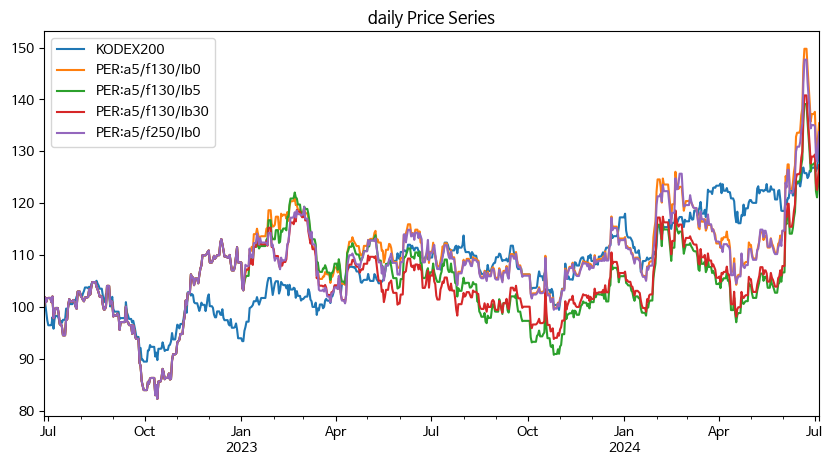

In [67]:
pf_list = list(range(5))
_ = bm.plot(pf_list, figsize=(10,5))

# Transaction

In [16]:
df_ratio = fratios_dict['PER']

In [17]:
kwargs = dict(
    name='PER',
    #file='pf_k200_per.csv',
    file='test_per.csv',
    path=path_tran,
    days_in_year=246,
    asset_names=assetnames_k200,
    lookback='5 days', # days
    df_additional=df_ratio,
    method_weigh='equally',
)
kwargs.update(MomentumPortfolio.check_init_args('per'))

pf_per = MomentumPortfolio(df_k200, **kwargs)

201 assets from 2021-01-04 to 2024-10-18 uploaded.
running self.util_check_days_in_year to check days in a year
REMINDER: make sure this is 1st transaction as no records provided


In [23]:
pf_per.view_record()

name  price  transaction  net weight weight*
date       asset                                                   
2024-04-30 011200       HMM  15850          126  126  0.200  0.2008
           137310  에스디바이오센서  10540          189  189  0.200  0.2003
           016380      KG스틸   7120          280  280  0.200  0.2005
           036460    한국가스공사  27600           72   72  0.200  0.1998
           139480       이마트  63700           31   31  0.200  0.1986

Portfolio value 10,673,530, Profit 7.3% on 2024-10-18


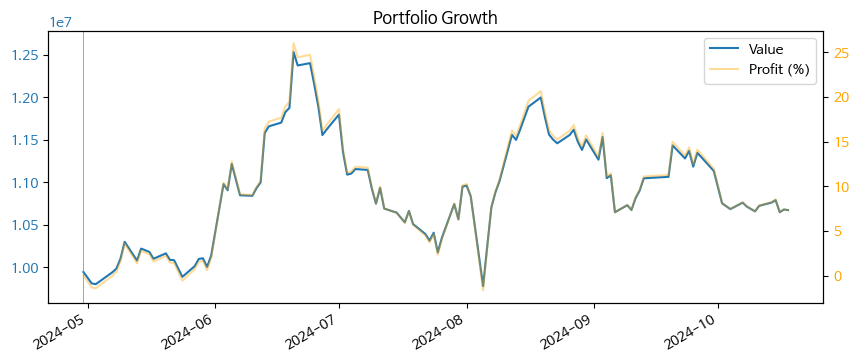

In [24]:
pf_per.valuate()

In [20]:
# set kwargs of transaction_pipeline
WidgetTransaction

In [21]:
kwargs_trs = dict(
    n_assets = 5,
    date = WidgetTransaction.values(0),
    capital = WidgetTransaction.values(1),
    save = WidgetTransaction.values(2)
)

_ = pf_per.transaction_pipeline(**kwargs_trs)
pf_per.view_record()

Liquidation set to None
5 assets selected by Financial Ratio from 2024-04-25 to 2024-04-30
Weights of assets determined by Equal weights.
Mean absolute error of weights: 1 %
Portfolio value 10,673,530, Profit 7.3% on 2024-10-18
Set save=True to save transaction record


name  price  transaction  net weight weight*
date       asset                                                   
2024-04-30 011200       HMM  15850          126  126  0.200  0.2008
           137310  에스디바이오센서  10540          189  189  0.200  0.2003
           016380      KG스틸   7120          280  280  0.200  0.2005
           036460    한국가스공사  27600           72   72  0.200  0.1998
           139480       이마트  63700           31   31  0.200  0.1986

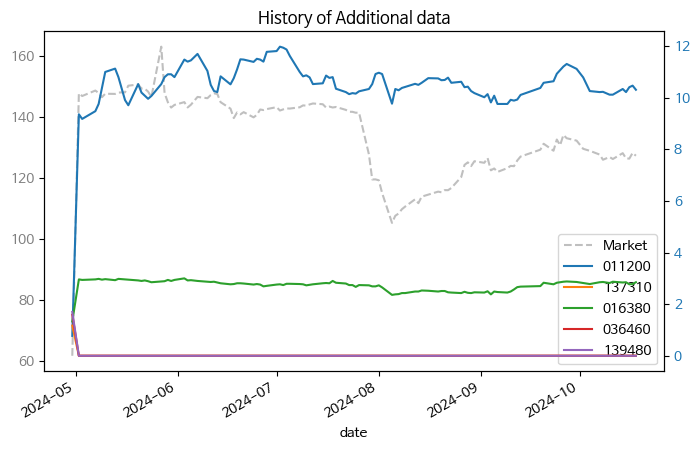

In [22]:
_ = pf_per.check_additional(plot=True)

# testing

In [59]:
df_ratio

ticker,000080,000100,000120,000150,000210,000240,000270,000660,000670,000720,...,361610,373220,375500,377300,383220,402340,450080,454910,457190,489790
date,,,,,,,,,,,,,,,,,,,,,
2023-01-02,23.67,39.41,49.43,6.46,1.37,6.64,5.18,5.41,8.09,9.27,...,38.67,112.54,1.20,0.00,23.10,12.40,NaN,NaN,NaN,NaN
2023-01-03,23.38,38.85,48.72,6.85,1.35,6.45,5.26,5.40,8.08,9.45,...,38.02,111.15,1.21,0.00,22.93,12.06,NaN,NaN,NaN,NaN
2023-01-04,23.42,38.57,47.64,6.80,1.38,6.30,5.22,5.79,8.49,9.90,...,38.81,111.78,1.26,0.00,22.44,12.61,NaN,NaN,NaN,NaN
2023-01-05,23.38,38.29,48.51,6.67,1.38,6.38,5.15,5.82,8.45,9.85,...,40.24,109.39,1.26,0.00,22.36,12.59,NaN,NaN,NaN,NaN
2023-01-06,23.52,38.23,48.18,7.06,1.40,6.23,5.18,5.94,8.45,10.37,...,41.25,112.04,1.34,0.00,20.79,12.83,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-14,39.65,86.94,8.71,0.00,0.00,8.67,4.54,0.00,0.00,6.31,...,30.69,76.79,6.35,1302.63,5.90,0.00,1385.88,0.0,0.0,0.0
2024-10-15,39.55,90.19,8.59,0.00,0.00,8.51,4.50,0.00,0.00,6.27,...,30.34,76.32,6.44,1310.53,5.70,0.00,1320.00,0.0,0.0,0.0
2024-10-16,39.36,87.33,8.57,0.00,0.00,8.75,4.41,0.00,0.00,6.22,...,29.21,76.51,6.40,1300.00,5.54,0.00,1352.94,0.0,0.0,0.0


In [61]:
bm.df_assets

,005930,000660,373220,207940,005380,068270,000270,105560,055550,035420,...,016380,032350,039130,069260,093370,114090,001430,009900,178920,105630
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,83000,126000,NaN,819298,207500,328540,64000,42450,31550,293000,...,12150,15150,56168,26600,12061,16450,10800,48400,37050,16750
2021-01-05,83900,130500,NaN,822263,209500,335158,63700,43550,32100,292500,...,12950,15150,56461,25950,11866,16450,11600,48300,37000,16550
2021-01-06,82200,131000,NaN,807438,203000,334213,62200,44000,32400,290000,...,13000,15200,56364,25250,11475,16250,11550,46300,36550,16200
2021-01-07,82900,134500,NaN,809415,206000,337995,63000,46000,33750,289500,...,13000,15050,56071,26100,11914,16200,11600,44000,36650,16200
2021-01-08,88800,138000,NaN,827204,246000,346976,68300,46500,33650,312000,...,12650,15100,55778,26000,11719,16250,12000,45750,36500,15850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-14,60800,187500,406000.0,1036000,248500,195800,100600,97200,58100,171400,...,6650,9840,50200,19810,6400,11190,20050,12680,20450,16480
2024-10-15,61000,192900,403500.0,1082000,246000,200500,99700,95600,57800,175200,...,6670,9970,49350,19720,6290,11130,19920,12420,20500,16460
2024-10-16,59500,188700,404500.0,1057000,247000,195800,97800,95400,56400,177000,...,6480,9880,50200,20600,6220,11200,20900,12320,20400,16840


In [36]:
df_prc.loc[date, assets] 
#df_prc.loc[date.strftime(self.date_format), assets]

KeyError: datetime.date(2024, 5, 2)

In [29]:
date.strftime(self.date_format)

'2024-05-01'

In [37]:
df_prc.loc['2024-05-01']

KeyError: '2024-05-01'